# Plot Attributes with respect to AvgFuelConsumption_per100km

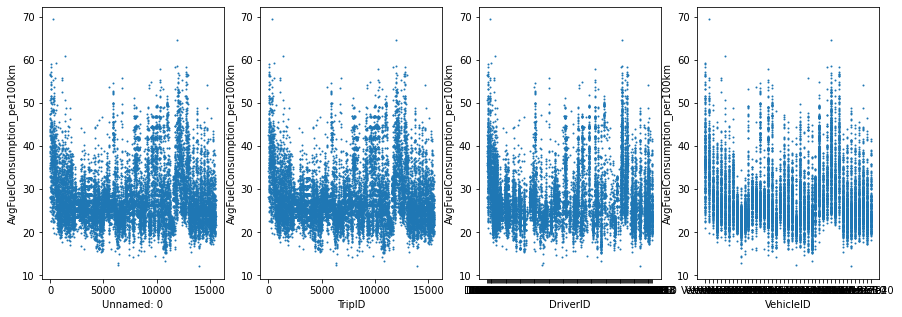

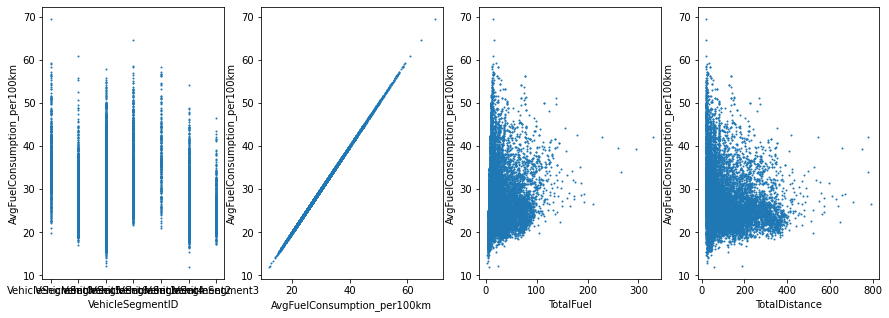

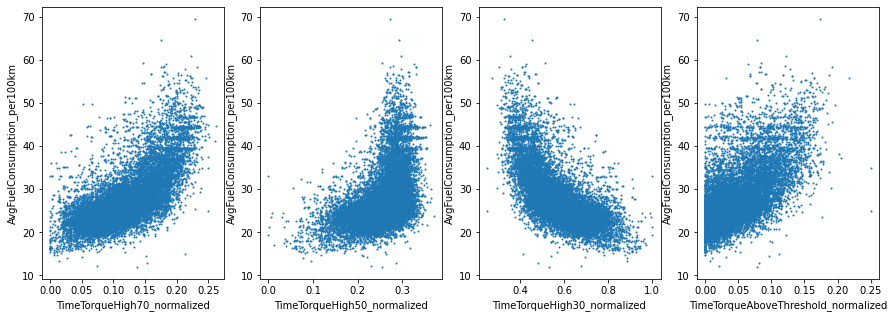

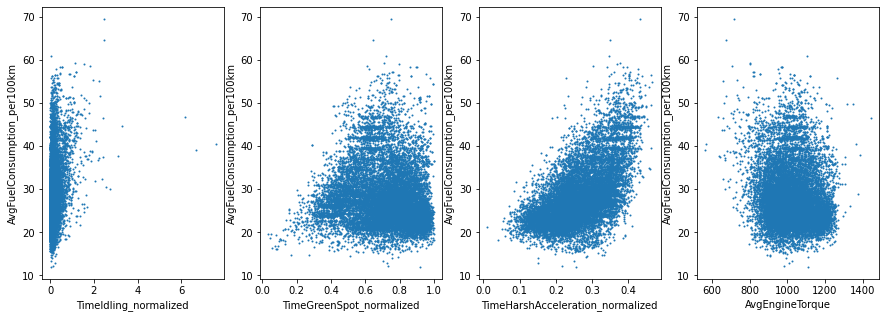

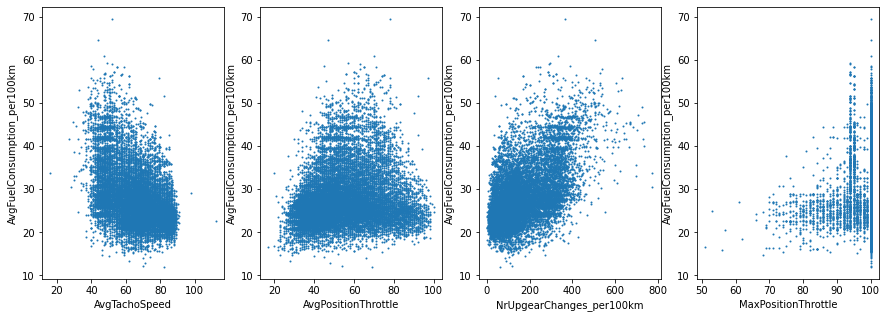

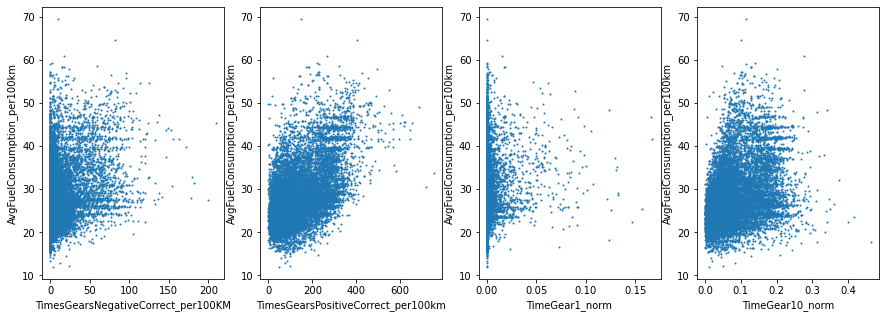

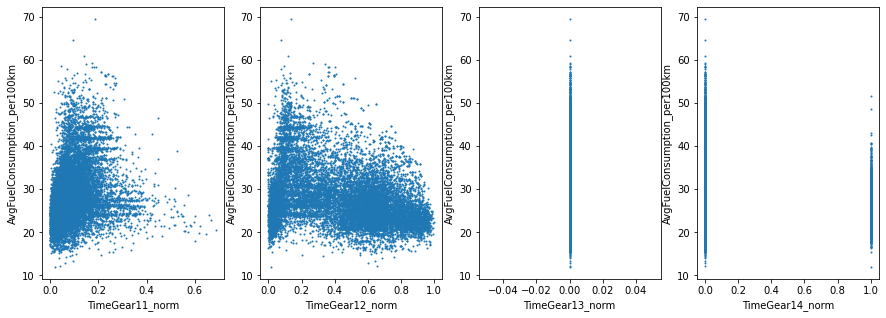

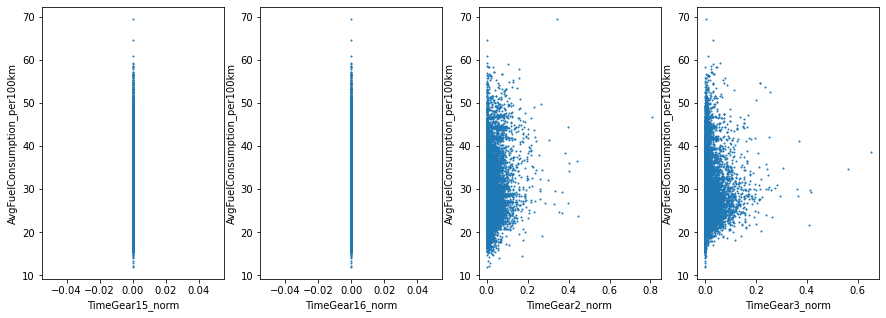

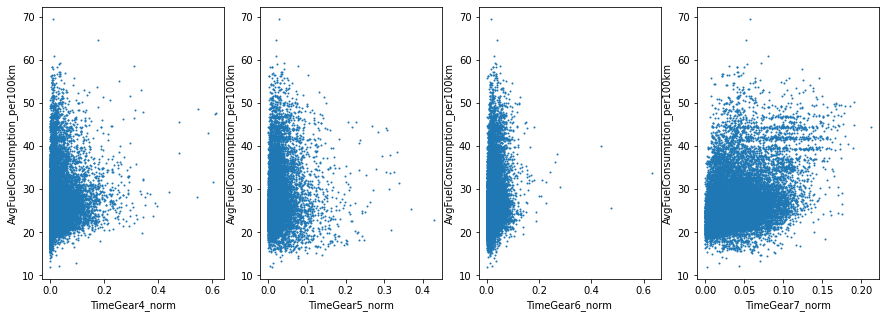

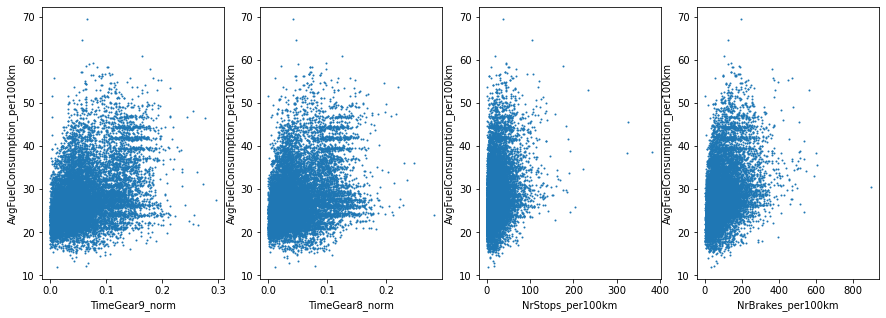

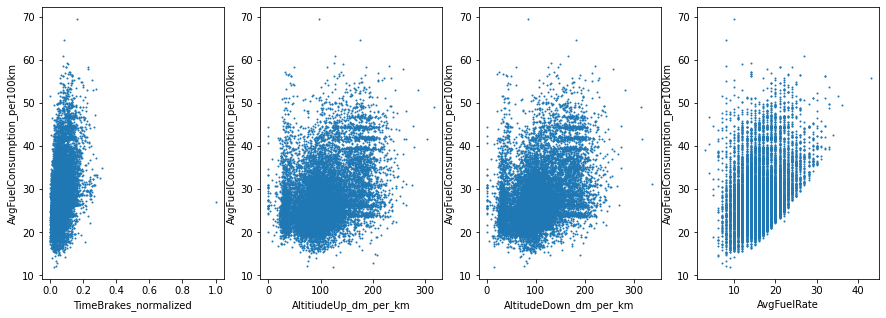

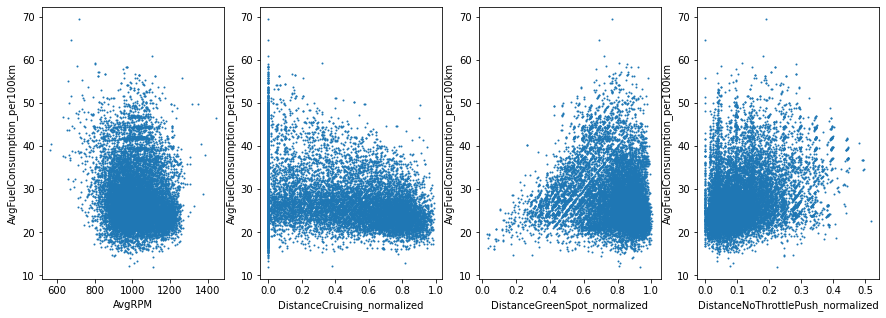

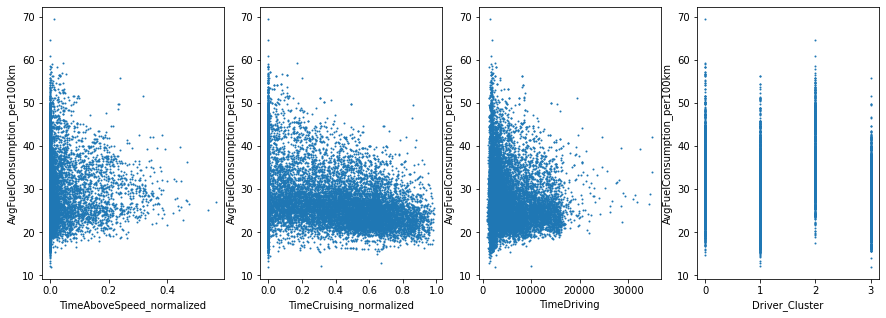

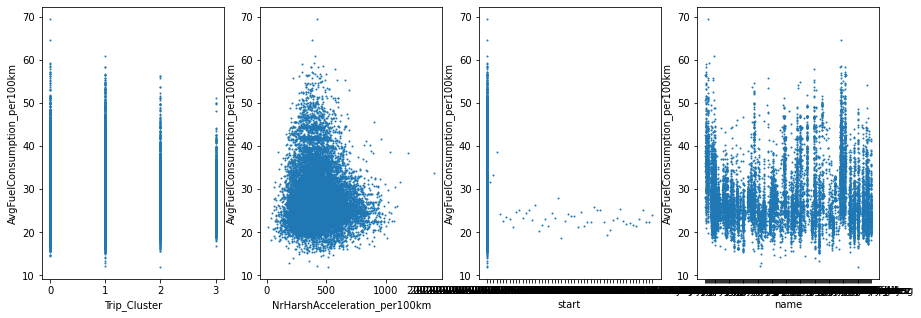

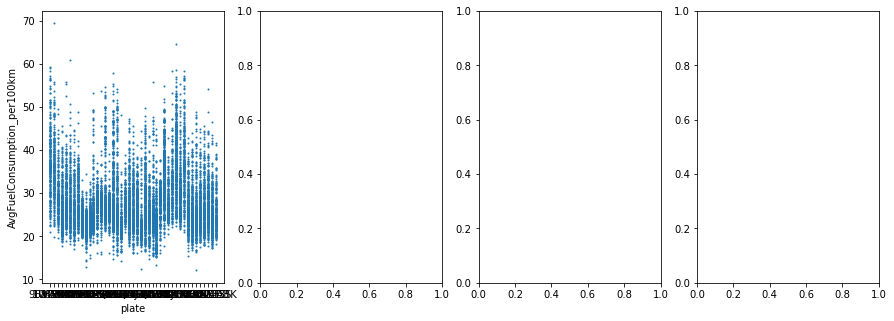

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

y_key = "AvgFuelConsumption_per100km"

for i, k in enumerate(ZF_DATA_timestamped.keys()):
    if i%4 == 0:
        if i > 0:
            plt.show()
        fig, axs = plt.subplots(1,4, figsize=(15,5))
    
    ZF_DATA_timestamped.plot.scatter(x=k,y=y_key, ax=axs[i%4], s=1)    

# Correlation coefficients between attributes after removing categorical data

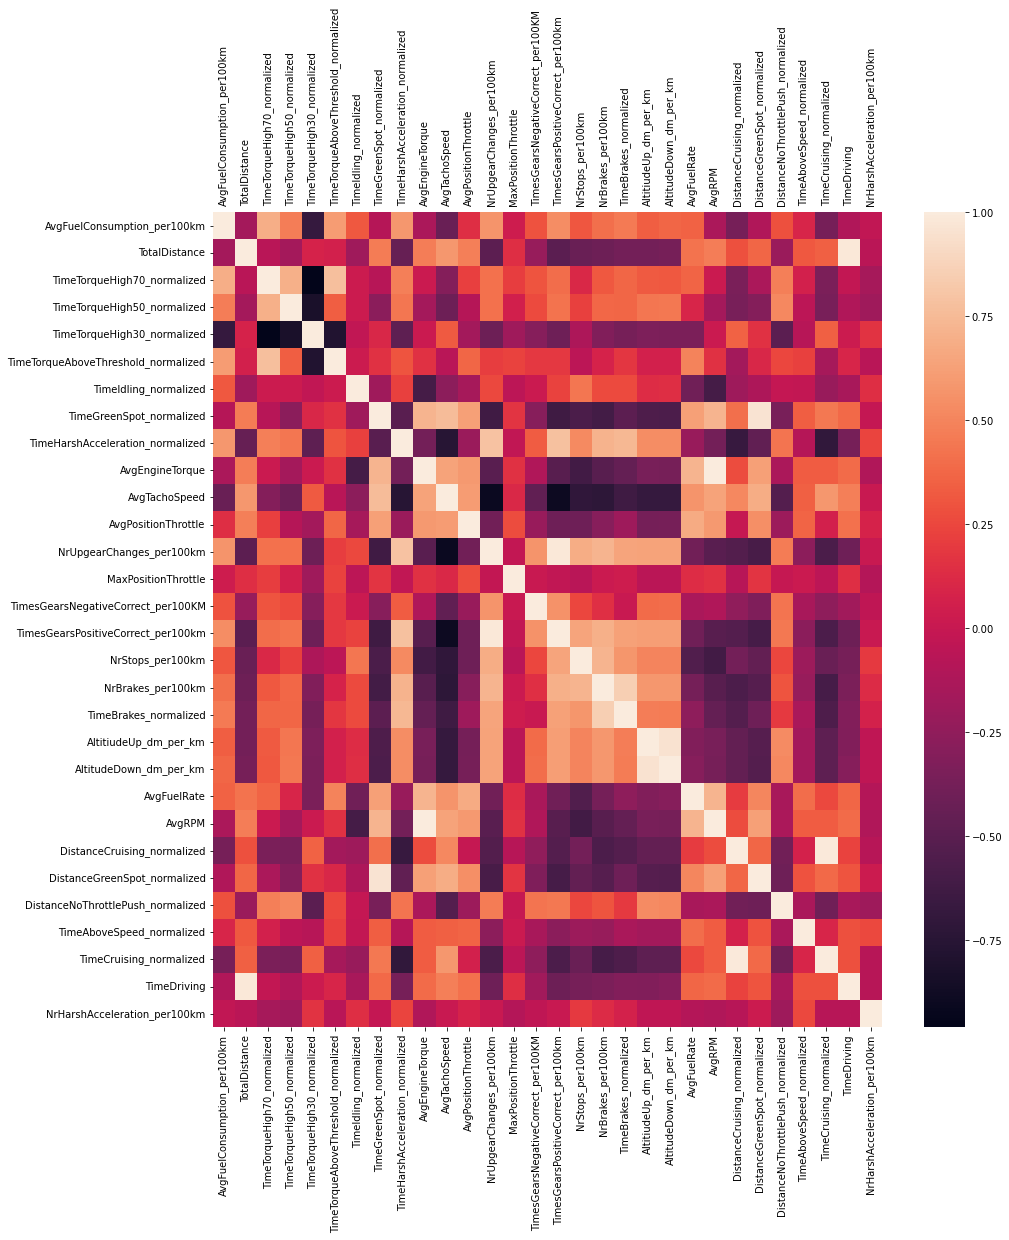

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

ZF_DATA_timestamped = pd.read_csv("Data/Export_data_ZF_tsv2.csv")

clean_df = ZF_DATA_timestamped.copy()

categorical_columns = [
    'DriverID', 'VehicleID', 'VehicleSegmentID', 'TripID','Driver_Cluster','Trip_Cluster',
    'TotalFuel', 'TimeGear13_norm','TimeGear15_norm','TimeGear16_norm',
    'start', 'name', 'plate'] # 'TotalDistance', 'TimeDriving'

time_gear = [k for k in list(KEYS) if "TimeGear" in k]

clean_df = clean_df.drop(columns=categorical_columns + time_gear)

fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.tick_params(labeltop=True, labelbottom=True)
_ = sns.heatmap(clean_df.corr(), ax=ax)

# PCA between mean vehicle attributes

In [212]:
from sklearn.decomposition import PCA
vehicle_df = clean_df
vehicle_df[KEYS.VehicleID] = ZF_DATA_timestamped[KEYS.VehicleID]
vehicle_df[KEYS.TotalDistance] = vehicle_df[KEYS.TotalDistance]
vehicle_df = vehicle_df.groupby(KEYS.VehicleID).mean()


pca = PCA(n_components=len(vehicle_df.keys()))
normalized_df=(vehicle_df-vehicle_df.mean())/vehicle_df.std()

# Divide each attribute by AvgFuelConsumption_per100km to get a score with respect to AvgFuelConsumption_per100km
vehicledf_per_avgfuelper100 = pd.DataFrame(
    np.array(normalized_df)/np.array(normalized_df['AvgFuelConsumption_per100km'])[:,None],
    columns=normalized_df.keys())
pca.fit(vehicledf_per_avgfuelper100)

PCA(n_components=30)

# First 4 principal components capture 95% of the variance

[0.52944234 0.84492236 0.92177918 0.9534044 ]


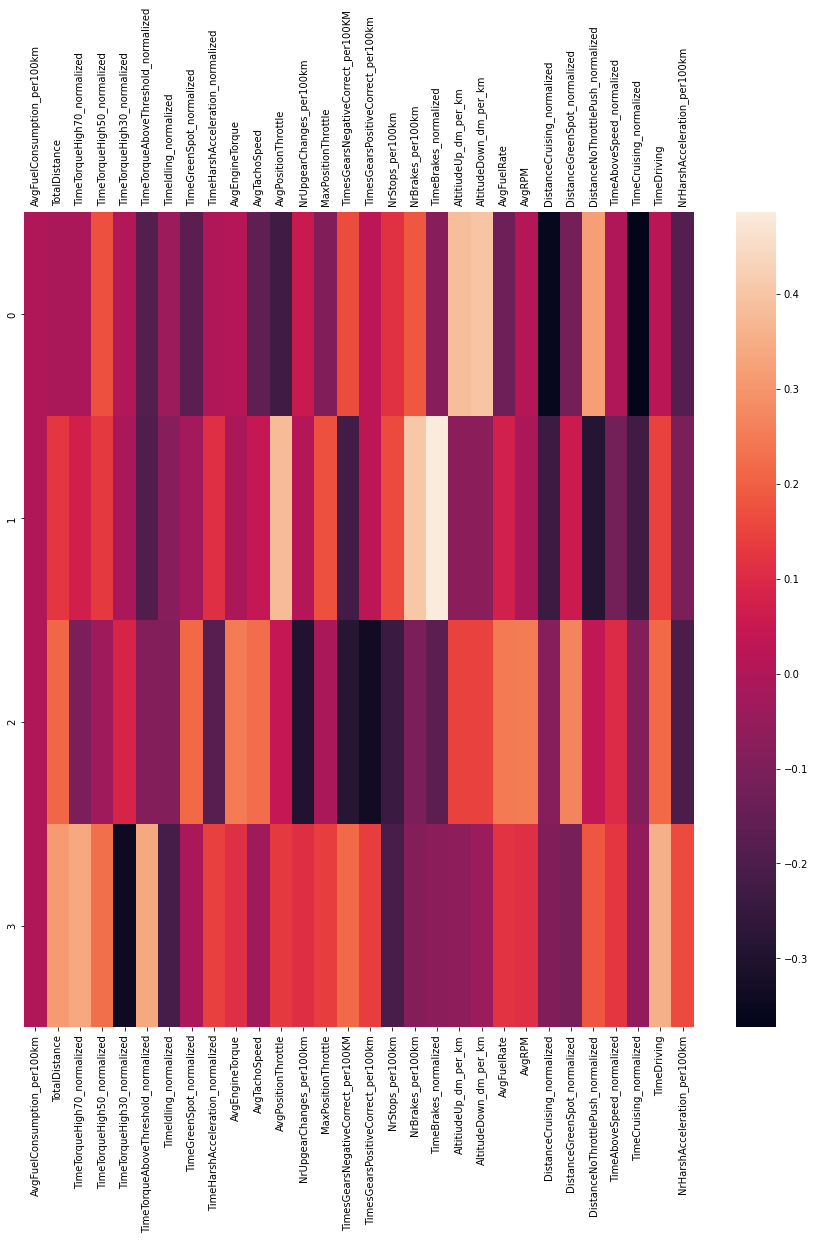

In [213]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plt.tick_params(labeltop=True, labelbottom=True)
sns.heatmap(pd.DataFrame(pca.components_[:4], columns=vehicledf_per_avgfuelper100.keys()))

print(np.cumsum( pca.explained_variance_ / pca.explained_variance_.sum())[:4])
# print(pca.explained_variance_ / pca.explained_variance_.sum())

In [226]:
used = set()
for i in range(5):
    top_frompc = np.array(vehicledf_per_avgfuelper100.keys())[ (pca.components_[i]**2).argsort()[::-1] ]
    top_frompc = [attr for attr in top_frompc if attr not in used]
    used.update(set(top_frompc[:5]))
    print(top_frompc[:5])

['AltitudeDown_dm_per_km', 'AltitiudeUp_dm_per_km', 'TimeCruising_normalized', 'DistanceCruising_normalized', 'DistanceNoThrottlePush_normalized']
['TimeBrakes_normalized', 'NrBrakes_per100km', 'AvgPositionThrottle', 'TimesGearsNegativeCorrect_per100KM', 'TimeTorqueAboveThreshold_normalized']
['TimesGearsPositiveCorrect_per100km', 'NrUpgearChanges_per100km', 'DistanceGreenSpot_normalized', 'AvgEngineTorque', 'AvgRPM']
['TimeDriving', 'TimeTorqueHigh30_normalized', 'TimeTorqueHigh70_normalized', 'TotalDistance', 'TimeTorqueHigh50_normalized']
['MaxPositionThrottle', 'TimeGreenSpot_normalized', 'NrHarshAcceleration_per100km', 'AvgTachoSpeed', 'TimeHarshAcceleration_normalized']


In [229]:
import random
import pandas as pd
from collections import namedtuple
# ZF_DATA = pd.read_csv("Data/Export_data_ZF.csv")
ZF_DATA = c
ZF_KEYS = namedtuple("ZF_KEYS", ZF_DATA.keys())
KEYS = ZF_KEYS( **{k:k for k in ZF_DATA.keys()} )

def get_best_avgs(attributes, group_by, normalize=True, weights = None):
    if normalize:
        normalized_attributes = (ZF_DATA[attributes] - ZF_DATA[attributes].mean()) / ZF_DATA[attributes].std()
    else:
        normalized_attributes = ZF_DATA[attributes].copy()
        
    for i, k in enumerate(attributes):
#         if not use_min_:
#             normalized_attributes[k] = normalized_attributes[k] * -1
        if weights is not None:
            normalized_attributes[k] = normalized_attributes[k] * weights[i]
            
    normalized_attributes['ACC'] = normalized_attributes.sum(axis=1)
    normalized_attributes[group_by] = ZF_DATA[group_by]
    
    avg_values = normalized_attributes.groupby(group_by)['ACC'].mean()
    
    return avg_values.keys()[avg_values.argmax() ]
    

def get_vehicle(selection_criteria, weights=None):
#     selection_criteria = [KEYS.AvgFuelConsumption_per100km, KEYS.TotalDistance]
    best_id = get_best_avgs(selection_criteria, group_by=KEYS.VehicleID, weights=weights)
    return best_id # ZF_DATA[ZF_DATA[KEYS.VehicleID] == best_id][selection_criteria].mean()

def get_driver(selection_criteria, weights=None):
    best_id = get_best_avgs(selection_criteria, group_by=KEYS.DriverID, weights=weights)
    return best_id # , ZF_DATA[ZF_DATA[KEYS.DriverID] == best_id][selection_criteria].mean()

In [238]:
def show(**weights):
    crit = [k for k,w in weights.items() if w != 0.]
    weights = [w for w in weights.values() if w != 0.]
    
#     crit = [KEYS.AvgFuelConsumption_per100km, KEYS.TotalDistance]
    best_vehicle = get_vehicle(crit, weights=weights)
    best_driver = get_driver(crit, weights = weights)
    
    print(best_vehicle)
    print(ZF_DATA[ZF_DATA[KEYS.VehicleID] == best_vehicle][crit].mean())
    print(ZF_DATA[ZF_DATA[KEYS.VehicleID] == best_vehicle][[KEYS.AvgFuelConsumption_per100km]].mean())
    
    print(best_driver)
    print(ZF_DATA[ZF_DATA[KEYS.DriverID] == best_driver][crit].mean())
    print(ZF_DATA[ZF_DATA[KEYS.DriverID] == best_driver][[KEYS.AvgFuelConsumption_per100km]].mean())


from ipywidgets import interact
import ipywidgets as widgets

interact( show, **{k: widgets.FloatSlider(
    value=0.,min=-5,max=5,
    layout = widgets.Layout(overflow="flex", width="500px"), description=k.rjust(34,"_"),
    style={'description_width': 'initial'}
) for k in set(KEYS) - set(categorical_columns + time_gear)})


interactive(children=(FloatSlider(value=0.0, description='_________TimeAboveSpeed_normalized', layout=Layout(o…

<function __main__.show(**weights)>

In [350]:
import time
ZF_DATA_timestamped = ZF_DATA.copy()
ZF_DATA_timestamped['start'] = 0

driverids = set(ZF_DATA['DriverID'])

for driverid in driverids:
    zf_delta_driver = ZF_DATA_timestamped[ZF_DATA_timestamped['DriverID'] == driverid]
    ZF_DATA_timestamped.iloc[ZF_DATA_timestamped['DriverID'] == driverid, -1] = generate_timestamps_(zf_delta_driver)
    break

In [93]:
# ZF_DATA_timestamped.to_csv("Data/Export_data_ZF_ts.csv")
import pandas as pd
k = ['TripID', 'DriverID', 'VehicleID',
       'VehicleSegmentID', 'AvgFuelConsumption_per100km', 'TotalFuel',
       'TotalDistance', 'TimeTorqueHigh70_normalized',
       'TimeTorqueHigh50_normalized', 'TimeTorqueHigh30_normalized',
       'TimeTorqueAboveThreshold_normalized', 'TimeIdling_normalized',
       'TimeGreenSpot_normalized', 'TimeHarshAcceleration_normalized',
       'AvgEngineTorque', 'AvgTachoSpeed', 'AvgPositionThrottle',
       'NrUpgearChanges_per100km', 'MaxPositionThrottle',
       'TimesGearsNegativeCorrect_per100KM',
       'TimesGearsPositiveCorrect_per100km', 'TimeGear1_norm',
       'TimeGear10_norm', 'TimeGear11_norm', 'TimeGear12_norm',
       'TimeGear13_norm', 'TimeGear14_norm', 'TimeGear15_norm',
       'TimeGear16_norm', 'TimeGear2_norm', 'TimeGear3_norm', 'TimeGear4_norm',
       'TimeGear5_norm', 'TimeGear6_norm', 'TimeGear7_norm', 'TimeGear9_norm',
       'TimeGear8_norm', 'NrStops_per100km', 'NrBrakes_per100km',
       'TimeBrakes_normalized', 'AltitiudeUp_dm_per_km',
       'AltitudeDown_dm_per_km', 'AvgFuelRate', 'AvgRPM',
       'DistanceCruising_normalized', 'DistanceGreenSpot_normalized',
       'DistanceNoThrottlePush_normalized', 'TimeAboveSpeed_normalized',
       'TimeCruising_normalized', 'TimeDriving', 'Driver_Cluster',
       'Trip_Cluster', 'NrHarshAcceleration_per100km', 'start', 'name',
       'plate']

# pd.read_csv("Data/Export_data_ZF_ts.csv")[k].to_csv("Data/Export_data_ZF_tsv2.csv", index=False)

In [8]:
def generate_timestamps_(driver_zf_data):
    current_time = pd.Timestamp.now()
    driver_zf_start = []
    for i in driver_zf_data['TimeDriving'].iloc[::-1]:
        current_time -= pd.Timedelta(i, unit='s')
        noise = pd.Timedelta( np.random.randn(1)[0] * 2, unit='s' )
        current_time = current_time - pd.Timedelta(i, unit='s') + noise - pd.Timedelta(1, unit='d')
        driver_zf_start.append(str(current_time))

    return driver_zf_start[::-1]

In [24]:
import numpy as np
driverids = list(set(ZF_DATA_timestamped['DriverID']))
vehicleids = list(set(ZF_DATA_timestamped['VehicleID']))

In [25]:
# (ZF_DATA_timestamped['DriverID'] == 'Driver3').sum()
ZF_DATA_timestamped['plate'] = ''

import faker
f = faker.Faker()
for vid in vehicleids:
    ZF_DATA_timestamped.iloc[ZF_DATA_timestamped['VehicleID'] == vid, -1] = f.license_plate()

In [195]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def get_xy(y, start=0, end=-1, smoothen=True):
    y = np.array(y)
    x = np.arange(start, start + len(y) if end < 0 else end)
    return x, savgol_filter(y, 7, 3) if smoothen else y

def select_id_rows(id_, key_):
    return ZF_DATA_timestamped[ZF_DATA_timestamped[key_] == id_]

def select_driver(driverid):
    return select_id_rows(driverid, KEYS.DriverID)

def select_vehicle(vehicleid):
    return select_id_rows(vehicleid, KEYS.VehicleID)


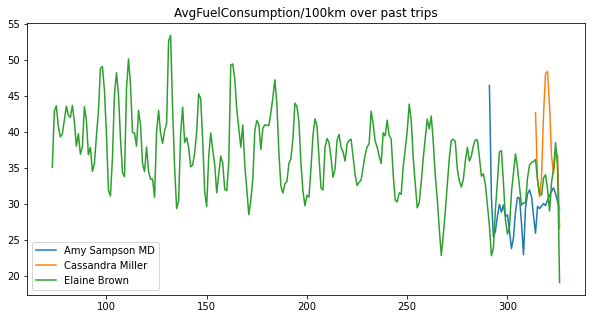

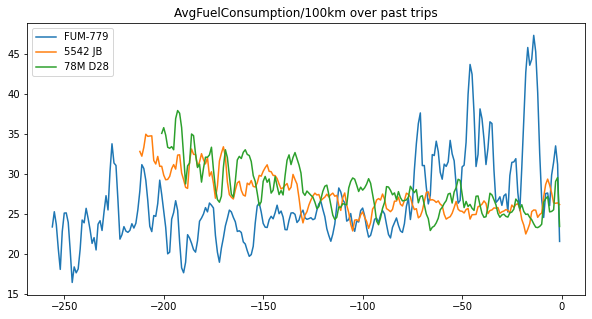

In [196]:
def plot_over_past_trips(selected_ids, key_, name_key=None):
    plt.figure(figsize=(10,5))
    
    driver_avgfuel = []
    # selected_drivers = ['Driver1','Driver2','Driver3']
    max_length = max([len(select_id_rows(s, key_)) for s in selected_drivers])

    for id_ in selected_ids:
        zf_data = select_id_rows(id_, key_)
        plt.plot(
            *get_xy(
                zf_data['AvgFuelConsumption_per100km'],
                start=max_length - len(zf_data), end=max_length),
            alpha=1, label=zf_data[name_key if name_key else key_].iloc[0])

    plt.legend()
    plt.title("AvgFuelConsumption/100km over past trips")
    
plot_over_past_trips(['Driver4','Driver5','Driver6'], KEYS.DriverID, 'name')
plt.show()
plot_over_past_trips(['Vehicle7','Vehicle8','Vehicle9'], KEYS.VehicleID, 'plate')